In [42]:
import numpy as np
from matplotlib import pyplot as plt

import os
import pickle
from time import time
from sklearn.decomposition import PCA

import george
from george import kernels
from scipy.optimize import minimize

%matplotlib inline

In [43]:
param_names = ["Tstar","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]
    
ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]
steps=[]
for i in range(len(ranges)):
    steps.append(np.linspace(ranges[i][0],ranges[i][1],11))

sl=[]
for i in range(11):
    x=[steps[0][i]]
    for j in range(len(ranges)-1):
        x.append(steps[j+1][5])
    sl.append(x)
    
dictionary=np.load("../grid_metadata/dictionary.npy")
    
# training set - read in filenames and logspace flux values
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    core= pickle.load(fp)[100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))[:,100:500]    
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)[100:500]
    
# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

fitdata=[]

for i in range(len(cube)):
    modeldata=[]
    coeffs=pca.transform(seds_msub[i].reshape(1,-1))
    for k in range(18):
        modeldata.append(coeffs[0][k])
    fitdata.append(modeldata)
    
def load_pcwpar(weight):
    p=[]
    w=[]
    for i in range(len(cube)):
        pars=[]
        for j in range(len(param_names)):
            pars.append(dictionary[i][param_names[j]])
        p.append(pars)
        w.append(fitdata[i][weight])
    
    return p,w

done in 0.168s


In [44]:
X, y = load_pcwpar(0)
yerr=[x*0.01 for x in y]

In [45]:
kernel = np.var(y) * kernels.ExpSquaredKernel(900**2,ndim=15,axes=0)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=1)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=2)*\
        kernels.ExpSquaredKernel(0.8**2,ndim=15,axes=3)*\
        kernels.ExpSquaredKernel(0.08**2,ndim=15,axes=4)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=5)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=6)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=7)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=8)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=9)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=10)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=11)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=12)*\
        kernels.ExpSquaredKernel(0.4**2,ndim=15,axes=13)*\
        kernels.ExpSquaredKernel(5**2,ndim=15,axes=14) 

gp = george.GP(kernel)
gp.compute(X,yerr)

In [46]:
gp.get_parameter_vector()

array([ 6.33043192, 13.60478953,  0.        ,  0.        , -0.4462871 ,
       -5.05145729, -1.38629436,  0.        , -3.21887582, -1.38629436,
       -3.21887582, -2.77258872, -2.77258872, -1.38629436, -1.83258146,
        3.21887582])

In [47]:
np.set_printoptions(suppress=True)
np.sqrt(np.exp(gp.get_parameter_vector()))
# check lengthscales from hyperparameter values

array([ 23.69386046, 900.        ,   1.        ,   1.        ,
         0.8       ,   0.08      ,   0.5       ,   1.        ,
         0.2       ,   0.5       ,   0.2       ,   0.25      ,
         0.25      ,   0.5       ,   0.4       ,   5.        ])

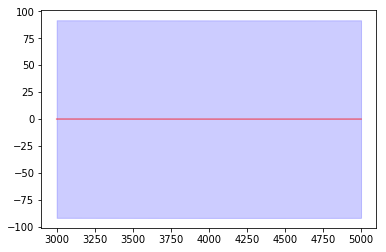

In [50]:
pred, pred_var = gp.predict(y, sl, return_var=True)
plt.fill_between(np.array(sl)[:,0], pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(np.array(sl)[:,0], pred, "r", lw=1.5, alpha=0.5)

In [40]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

Initial ln-likelihood: -22854.75


In [22]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

t0=time()

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

print("done in %0.3fs" % (time() - t0))

      fun: 17091.42452836227
 hess_inv: array([[ 2.28821594e-03,  1.98620809e-03,  1.03752672e-03,
         1.12207660e-03,  8.18761938e-04,  9.44088928e-04,
         1.15921343e-03,  2.52156005e+02,  1.41560419e-03,
         9.04795519e-04,  4.06522343e-04,  5.38134705e-04,
        -5.87448457e-04,  1.14207653e-03,  7.34656411e-04,
         1.02803001e-03],
       [ 1.98620809e-03,  2.31516686e-01,  8.93055592e-04,
         6.18155190e-03, -9.74060235e-03, -9.07053712e-03,
        -2.91662681e-03, -2.13474578e+03, -8.09775949e-03,
        -1.51823154e-03,  5.68521575e-03,  6.22833323e-03,
         3.45490615e-03, -9.30906054e-03, -7.03271759e-03,
        -5.79435041e-03],
       [ 1.03752672e-03,  8.93055592e-04,  6.27970996e-03,
         5.67413311e-04, -5.80235963e-04, -1.24501487e-03,
        -6.04096074e-04,  3.71297000e+02, -3.41745783e-04,
         2.31763763e-05, -1.33529122e-04,  9.93689931e-04,
        -3.95822187e-05,  1.04645023e-03, -6.06473090e-04,
         1.82259056e-04

In [23]:
np.sqrt(np.exp(gp.get_parameter_vector())) # check lengthscales from hyperparameter values

array([      18.7449328 ,    19202.79513449,        3.49052684,
              8.34942077,        1.16364912,        0.98044697,
              2.81945936, 12257955.53366096,        2.98424371,
              0.7957237 ,        0.42216087,        0.45512644,
              1.70644859,       16.0307036 ,        4.92046822,
            134.11594289])

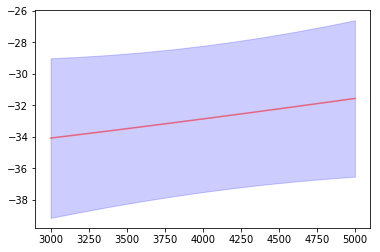

In [24]:
pred, pred_var = gp.predict(y, sl, return_var=True)

plt.fill_between(np.array(sl)[:,0], pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(np.array(sl)[:,0], pred, "r", lw=1.5, alpha=0.5)

In [25]:
X, y = load_pcwpar(1)
yerr=[x*0.01 for x in y]

In [26]:
kernel = kernels.ExpSquaredKernel(900**2,ndim=15,axes=0)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=1)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=2)*\
        kernels.ExpSquaredKernel(0.8**2,ndim=15,axes=3)*\
        kernels.ExpSquaredKernel(0.08**2,ndim=15,axes=4)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=5)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=6)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=7)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=8)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=9)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=10)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=11)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=12)*\
        kernels.ExpSquaredKernel(0.4**2,ndim=15,axes=13)*\
        kernels.ExpSquaredKernel(5**2,ndim=15,axes=14) * np.var(y)

gp = george.GP(kernel)
gp.compute(X,yerr)

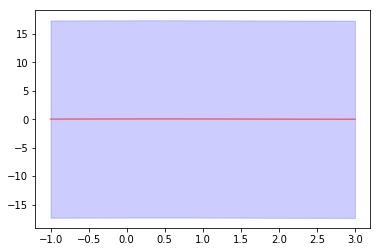

In [27]:
sl=[]
for i in range(11):
    x=[steps[0][5],steps[1][i]]
    for j in range(len(ranges)-2):
        x.append(steps[j+2][5])
    sl.append(x)

pred, pred_var = gp.predict(y, sl, return_var=True)
plt.fill_between(np.array(sl)[:,1], pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(np.array(sl)[:,1], pred, "r", lw=1.5, alpha=0.5)



In [28]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

Initial ln-likelihood: -16438.10


In [29]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

t0=time()

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

print("done in %0.3fs" % (time() - t0))

      fun: 13714.377924886961
 hess_inv: array([[ 0.00268967,  0.00220187,  0.00094883,  0.00064689,  0.00127546,
         0.00089503,  0.00200017,  0.00143001,  0.00070695,  0.00087902,
         0.00096636,  0.00150511,  0.00044871,  0.00154111,  0.00039384,
         0.00088915],
       [ 0.00220187,  0.22123354,  0.0037406 ,  0.00083396, -0.00233175,
        -0.00610359,  0.00824414, -0.02113534, -0.00616627, -0.00009192,
        -0.00213478,  0.00188037, -0.00946137,  0.00573871, -0.00458147,
        -0.00312615],
       [ 0.00094883,  0.0037406 ,  0.00632345, -0.00048708,  0.00013381,
        -0.00024703, -0.000161  , -0.0027508 , -0.00157909, -0.00018741,
        -0.0004211 ,  0.00073012, -0.0004608 , -0.00016105,  0.00328027,
        -0.00130121],
       [ 0.00064689,  0.00083396, -0.00048708,  0.00763585,  0.00016329,
         0.00061195, -0.00064015, -0.00191462, -0.00168347,  0.00067109,
         0.00019857, -0.00041503,  0.00068775, -0.0023865 , -0.00292335,
        -0.001276

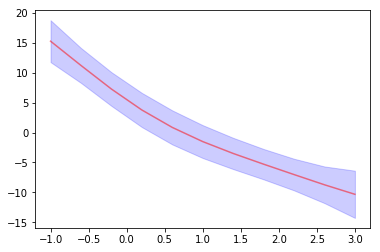

In [30]:
pred, pred_var = gp.predict(y, sl, return_var=True)
plt.fill_between(np.array(sl)[:,1], pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(np.array(sl)[:,1], pred, "r", lw=1.5, alpha=0.5)

In [31]:
np.sqrt(np.exp(gp.get_parameter_vector())) # check lengthscales from hyperparameter values

array([    5.30293311, 12400.85034293,     2.05015109,     4.53103753,
           1.12122896,     0.93516005,     3.26230654,     5.43634409,
           2.38468713,     0.58704676,     0.36831404,     0.49226837,
           2.80469154,    11.20609338,     7.21322   ,   106.04860638])

In [55]:
X, y = load_pcwpar(4)
yerr=[x*0.01 for x in y]

In [56]:
kernel = kernels.ExpSquaredKernel(900**2,ndim=15,axes=0)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=1)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=2)*\
        kernels.ExpSquaredKernel(0.8**2,ndim=15,axes=3)*\
        kernels.ExpSquaredKernel(0.08**2,ndim=15,axes=4)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=5)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=6)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=7)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=8)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=9)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=10)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=11)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=12)*\
        kernels.ExpSquaredKernel(0.4**2,ndim=15,axes=13)*\
        kernels.ExpSquaredKernel(5**2,ndim=15,axes=14) * np.var(y)

gp = george.GP(kernel)
gp.compute(X,yerr)

In [53]:
bases=[4000.0, 1.0, -5.0, 1.5, 0.255, 0.75, 1.0, 1.25, -5.0, 3.25, 0.5, 1.0, 2.5, 3.5, 45.0]

sl=[]
for i in range(15):
    sl.append(bases[i]*np.ones(11))
sl[6]=steps[6]
sl=np.transpose(sl)

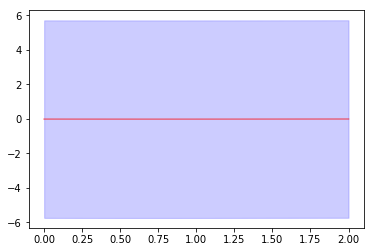

In [59]:
pred, pred_var = gp.predict(y, sl, return_var=True)
plt.fill_between(np.array(sl)[:,6], pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(np.array(sl)[:,6], pred, "r", lw=1.5, alpha=0.5)

In [60]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

t0=time()

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

print("done in %0.3fs" % (time() - t0))

ValueError: array must not contain infs or NaNs

In [ ]:
pred, pred_var = gp.predict(y, sl, return_var=True)
plt.fill_between(np.array(sl)[:,6], pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(np.array(sl)[:,6], pred, "r", lw=1.5, alpha=0.5)

In [ ]:
np.sqrt(np.exp(gp.get_parameter_vector())) # check lengthscales from hyperparameter values